In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load dataset
df = pd.read_csv('/content/sample_data/student_habits_performance.csv')
#  Data Cleaning
# -------------------------------
# Handle Missing Values
df['parental_education_level'] = df['parental_education_level'].fillna(df['parental_education_level'].mode()[0])
#drop unique ID
df.drop(columns=['student_id'], inplace=True)

#Outlier Detection & Treatment using IQR method
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = ['study_hours_per_day', 'social_media_hours', 'netflix_hours',
                  'attendance_percentage', 'sleep_hours', 'exercise_frequency',
                  'mental_health_rating', 'exam_score']
for col in numerical_cols:
    df = cap_outliers(df, col)

# -------------------------------
# Encoding Categorical Variables
# -------------------------------
#One-Hot Encoding for Nominal Categories

#Encode binary categorical variables (Yes/No) to 0 and 1
binary_cols = ['part_time_job', 'extracurricular_participation']
df[binary_cols] = df[binary_cols].replace({'No': 0, 'Yes': 1})


df = pd.get_dummies(df, columns=['gender', 'diet_quality', 'internet_quality', 'parental_education_level'], drop_first=True)

# Ordinal encoding for ordered categories (mental_health_rating)

ordinal_encoder = OrdinalEncoder(categories=[np.arange(1, 11)])
df['mental_health_rating'] = ordinal_encoder.fit_transform(df[['mental_health_rating']])

# -------------------------------
# Feature Scaling
# -------------------------------
# Standardize features with normal-like distribution
standard_scaler = StandardScaler()
std_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']
df[std_cols] = standard_scaler.fit_transform(df[std_cols])

# -------------------------------
# Feature Engineering
# -------------------------------
#Create Composite Features:
# Total screen time
df['total_screen_time'] = df['social_media_hours'] + df['netflix_hours']

# Lifestyle index (average of wellness-related normalized features)
wellness_features = ['sleep_hours', 'mental_health_rating', 'exercise_frequency']
df['lifestyle_index'] = df[wellness_features].mean(axis=1)

#Binning Continuous Variables
# Bin study hours
bins = [0, 2, 4, 6, 8]
labels = ['Low', 'Moderate', 'High', 'Very High']
df['study_category'] = pd.cut(df['study_hours_per_day'], bins=bins, labels=labels)

# Group by diet quality and get average exam score
grouped = df.groupby('diet_quality_Good')['exam_score'].mean()
print(grouped)

# Cluster students based on lifestyle behaviors
kmeans = KMeans(n_clusters=4, random_state=42)
df['behavior_cluster'] = kmeans.fit_predict(df[['study_hours_per_day', 'total_screen_time', 'sleep_hours', 'lifestyle_index']])

# -------------------------------
# Dimensionality Reduction
# -------------------------------
pca = PCA(n_components=2)
numeric_features = df.select_dtypes(include=np.number).drop(['exam_score'], axis=1)
pca_features = pca.fit_transform(numeric_features)
pca_df = pd.DataFrame(pca_features, columns=["PC1", "PC2"])
# Combine back with original dataframe
df = pd.concat([df.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)
# Convert 'exam_score' into performance categories
def categorize_score(score):
    if score < 50:
        return 'Low'
    elif 50 <= score <= 70:
        return 'Medium'
    else:
        return 'High'

df['performance_level'] = df['exam_score'].apply(categorize_score)
# Define features and target variable
X = df.drop('performance_level', axis=1)  # Exclude the target
y = df['performance_level']

#Select Important Features
important_features = [
    'study_hours_per_day',
    'total_screen_time',
    'sleep_hours',
    'attendance_percentage',
    'lifestyle_index',
    'mental_health_rating',
    'exercise_frequency'
]
X = df[important_features]
y = df['performance_level']

# -------------------------------
# Split into training and test sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df.head()





diet_quality_Good
False    69.746141
True     69.381746
Name: exam_score, dtype: float64


/tmp/ipython-input-2-103686298.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'No': 0, 'Yes': 1})


,age,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,extracurricular_participation,...,internet_quality_Poor,parental_education_level_High School,parental_education_level_Master,total_screen_time,lifestyle_index,study_category,behavior_cluster,PC1,PC2,performance_level
0,1.084551,-2.427520,-1.119948,-0.671029,0,0.092026,1.249227,1.461166,0.900186,1,...,False,False,True,-1.790977,1.203527,NaN,1,-2.346401,-2.497657,Medium
1,-0.215870,2.293751,0.255487,0.449921,0,1.403312,-1.526470,1.461166,0.900186,0,...,False,True,False,0.705409,0.278294,Moderate,3,1.037435,2.244840,High
2,0.217604,-1.469581,0.513381,-0.484204,0,1.136790,1.249227,-1.008689,-1.559339,0,...,True,True,False,0.029178,-0.439600,NaN,0,-0.072943,-1.681900,Low
3,1.084551,-1.743278,1.201099,-0.764441,0,-1.400495,2.228885,0.473224,-1.559339,1,...,False,False,True,0.436658,0.380923,NaN,0,0.280554,-2.864446,Low
4,-0.649344,0.993691,1.630923,-1.231504,0,0.721017,-1.281556,-0.020747,-1.559339,0,...,False,False,True,0.399419,-0.953881,Low,2,0.597871,1.869475,Medium


Model Training & Evaluation Section

In [3]:
# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred_cls = clf.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred_cls)
report = classification_report(y_test, y_pred_cls, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred_cls)

accuracy, report, conf_matrix

(0.8,
 {'High': {'precision': 0.8773584905660378,
   'recall': 0.8857142857142857,
   'f1-score': 0.8815165876777251,
   'support': 105.0},
  'Low': {'precision': 0.8421052631578947,
   'recall': 0.5714285714285714,
   'f1-score': 0.6808510638297872,
   'support': 28.0},
  'Medium': {'precision': 0.68,
   'recall': 0.7611940298507462,
   'f1-score': 0.7183098591549296,
   'support': 67.0},
  'accuracy': 0.8,
  'macro avg': {'precision': 0.7998212512413109,
   'recall': 0.7394456289978678,
   'f1-score': 0.7602258368874807,
   'support': 200.0},
  'weighted avg': {'precision': 0.8063079443892751,
   'recall': 0.8,
   'f1-score': 0.7987491602838773,
   'support': 200.0}},
 array([[93,  0, 12],
        [ 0, 16, 12],
        [13,  3, 51]]))

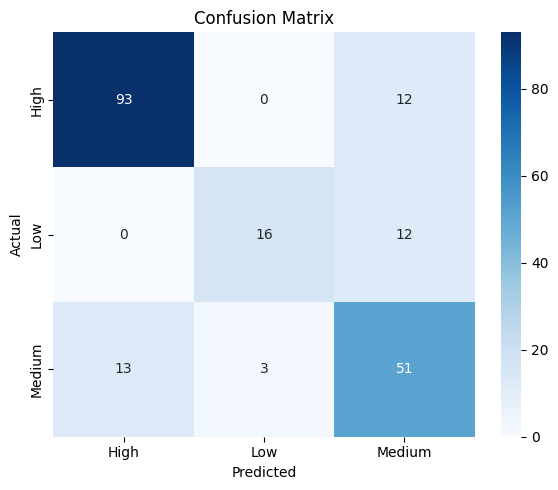

In [4]:
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

/tmp/ipython-input-5-141203579.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


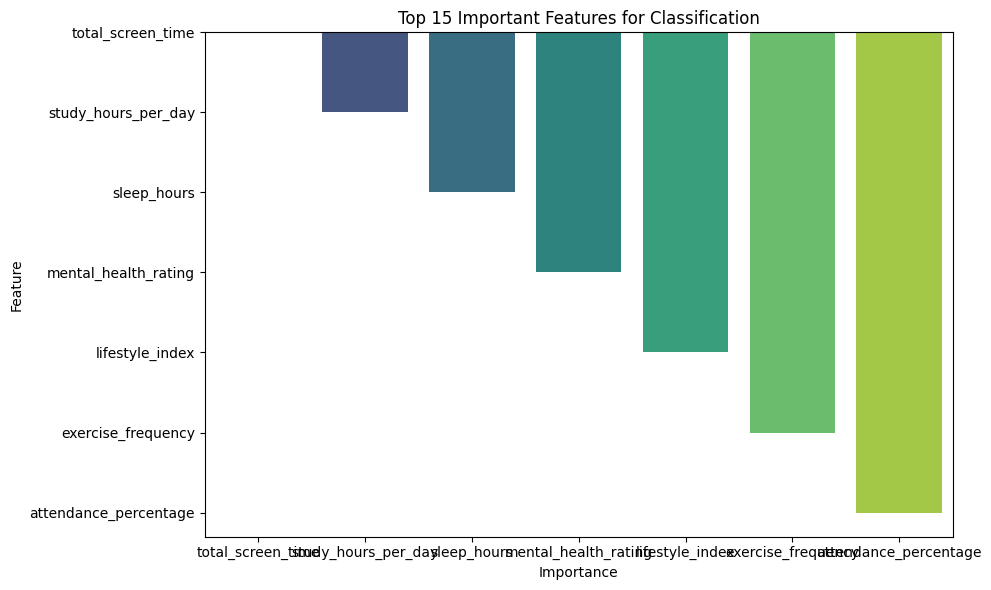

In [5]:
# Plot top 15 feature importances
importance_df = pd.DataFrame({'Feature':X.columns, 'Importance': important_features})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Important Features for Classification')
plt.tight_layout()
plt.show()